# Importing all the Required packages that we'll use first

In [110]:
import random
import pickle
import time
import pathlib

import pandas as pd
import numpy as np
import rasterio as rio
import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import matplotlib.font_manager
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.neural_network import MLPClassifier # Maybe we'll use this instead
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import ShuffleSplit
# from sklearn.cluster import KMeans
# from sklearn.cluster import SpectralClustering
# from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from yellowbrick.regressor import PredictionError
from sklearn.metrics import r2_score
# from sklearn.metrics import precision_score, recall_score, make_scorer
# from scipy.cluster.hierarchy import fcluster
# import cartopy

coreLimit = int(336*(6/8)) # Parallel Processing # 336 Total Cores Available
# Predicting on biomass_mg

## Creating a Data Handling Class for ease of passing data around. 

In [111]:
class Data():
    def __init__(self, X=None, Y=None):
        if X != None:
            self.__x = X
        else:
            self.__x = 0
        if Y != None:
            self.__y = Y
        else:
            self.__y = 0

    def __del__(self):
        del self.__x, self.__y

    def set_x(self, X):
        self.__x = X

    def set_y(self, Y):
        self.__y = Y
        
    def get_x(self):
        return self.__x

    def get_y(self):
        return self.__y
# end Data

## Reading Data into Memory

In [164]:
USFS_forest_file = 'data/csv_files/USFS_forest_biomass_mg_ha_Privategt50%_CAORWA_Unburned_random_10K.csv'
USFS_forest = pd.read_csv(USFS_forest_file)

# Removing invalid data (i.e., -9999.0)
count = 0
for i in USFS_forest:
    USFS_forest = USFS_forest[USFS_forest[i] != -9999.0] # Recreating dataset without invalid rows
    if i == 'Age2018' or i == 'biomass_mg':
        USFS_forest = USFS_forest[USFS_forest[i] != 0]
USFS_forest['Carbon2018'] = USFS_forest['Carbon2018']*11.11
print(USFS_forest.describe()) # Post-Removal

print(USFS_forest.head())

                  id   NDVI_Jun13   NDMI_Jun13    PRISM_ppt   PRISM_tave  \
count    8974.000000  8974.000000  8974.000000  8974.000000  8974.000000   
mean   150377.090372  3718.534999  2573.091246  1844.852920     9.865800   
std     86870.722503  1008.902601  1038.802994   799.249613     1.604252   
min        37.000000   526.493000 -1539.970000   264.963000     4.600000   
25%     76159.500000  3010.157500  2120.062500  1323.510000     9.119900   
50%    150147.000000  3767.335000  2821.760000  1818.985000    10.070000   
75%    225756.000000  4486.300000  3302.072500  2340.010000    10.850000   
max    299930.000000  6254.720000  4616.590000  5057.150000    15.420000   

        biomass_mg   Carbon2018    Stock2018      Age2018   Height2018  \
count  8974.000000  8974.000000  8974.000000  8974.000000  8974.000000   
mean    207.343214    52.449871    56.094156    64.437761    68.350370   
std      80.446479    33.962805    14.186152    38.423668    22.252796   
min       8.966810 

### Graphing Just the Age2018 and Carbon2018 Columns

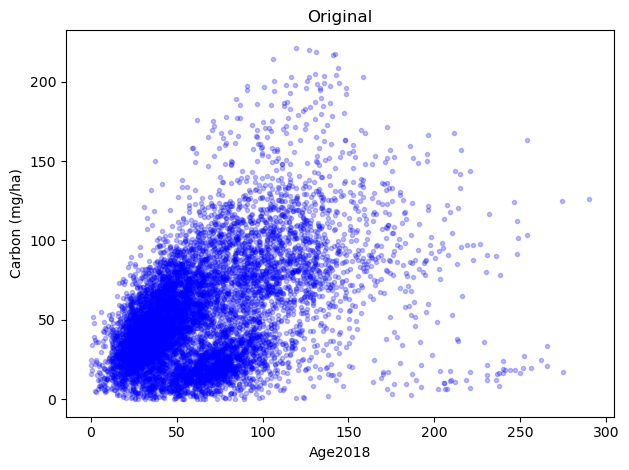

In [113]:
plot1 = plt.scatter( 
    USFS_forest['Age2018'], 
    USFS_forest['Carbon2018'],
    label = 'Original',
    # c=kmeans_rf.best_estimator_['model'].labels_,
    color = 'blue', 
    marker='.', 
    alpha=0.25
)
plt.ylabel('Carbon (mg/ha)')
plt.xlabel('Age2018')
plt.title('Original')
# plt.legend(handles=[plot1], loc='best',)
plt.tight_layout()
plt.show()

### Gathering the data and creating our model

In [114]:
# Splitting the Data
scatter_data = USFS_forest[['Age2018', 'Carbon2018']].values
# x_train, x_test = train_test_split(
#     scatter_data,
#     train_size=0.8,
# )
# model_data_cluster = Data() # A container for our data
# model_data_cluster.set_x([x_train, x_test])

cluster = OPTICS(n_jobs=coreLimit, max_eps=6, min_samples=2**7) #max_eps=2 produced some good results 


### Fitting the model to the data

In [115]:
print('Fitting the model to the data...')
timeStart = time.time()
# cluster_rf = cluster.fit(model_data_cluster.get_x()[0])
cluster_rf = cluster.fit(scatter_data)
print('Fit completed in '+str(round((time.time()-timeStart)//60))+' minutes and '+str(round((time.time()-timeStart)%60, 1))+' seconds.')

Fitting the model to the data...
Fit completed in 2 minutes and 19.2 seconds.


### Plotting

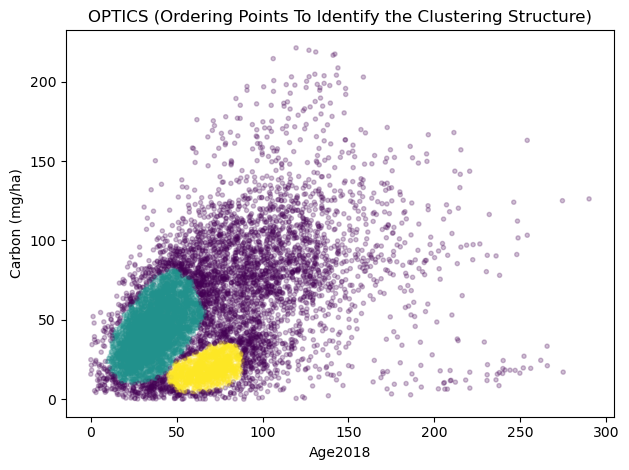

In [116]:
plot1 = plt.scatter(
    # model_data_cluster.get_x()[0][:, 0],
    # model_data_cluster.get_x()[0][:, 1],
    scatter_data[:, 0],
    scatter_data[:, 1],
    c=cluster_rf.labels_,
    marker='.', 
    alpha=0.25
)
# print(plot1.get_color())
# plot2 = plt.plot(np.NaN, np.NaN, '-', color='none', label='')

# plot2 = plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
#             marker='s', color='orange', s=100, alpha=0.5, label='pred')
plt.ylabel('Carbon (mg/ha)')
plt.xlabel('Age2018')
plt.title('OPTICS (Ordering Points To Identify the Clustering Structure)')
# plt.legend(handles=[plot1, plot2], loc='best',)
plt.tight_layout()
plt.show()

### Adding lavels to the original data and saving to CSV file

In [170]:
# USFS_forest = pd.DataFrame({
#     'Age2018':scatter_data[:, 0],
#     'Carbon2018':scatter_data[:, 1],
#     'labels':cluster_rf.labels_,
# })
# print(cluster_rf.labels_.shape)
# idList = []
# newDF = pd.DataFrame({'Carbon2018':scatter_data[:, 0], 'Age2018':scatter_data[:, 1], 'labels': cluster_rf.labels_})
# for i, row in newDF.iterrows():
#     # print(i, row)
#     for k, rows in USFS_forest.iterrows():
#         if row['Age2018'] == rows['Age2018']:
#             if row['Carbon2018'] == rows['Carbon2018']:
#                 idList.append(rows['id'])
# print(idList)

# newDF = pd.DataFrame({
#     'Carbon2018':USFS_forest['Carbon2018'],
#     'Age2018':USFS_forest['Age2018'],
#     # 'Carbon2018':scatter_data[:, 0],
#     # 'Age2018':scatter_data[:, 1],
#     'labels':cluster_rf.labels_,
# })

USFS_forest['labels'] = cluster_rf.labels_
newDF = USFS_forest
# print(cluster_rf.labels_)
# print(cluster_rf.ordering_)

# print(USFS_forest['Age2018'])
# USFS_forest['labels'] = cluster_rf.labels_
# USFUS_forest = pd.DataFrame({
#     USFS_forest,
#     'labels': cluster_rf.labels_
# })
# df = pd.merge(USFS_forest, newDF)
# USFS_forest.join(newDF)
# USFS_forest.head(50)

USFS_forest.to_csv('./data/csv_files/USFS_forest_clustered_great.csv')
USFS_forest.describe()
# USFS_forest.tail(50)

,id,NDVI_Jun13,NDMI_Jun13,PRISM_ppt,PRISM_tave,biomass_mg,Carbon2018,Stock2018,Age2018,Height2018,POINT_X,POINT_Y,labels
count,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000
mean,150377.090372,3718.534999,2573.091246,1844.852920,9.865800,207.343214,52.449871,56.094156,64.437761,68.350370,-122.686988,45.257364,-0.309004
std,86870.722503,1008.902601,1038.802994,799.249613,1.604252,80.446479,33.962805,14.186152,38.423668,22.252796,1.635502,2.344119,0.677456
min,37.000000,526.493000,-1539.970000,264.963000,4.600000,8.966810,0.018302,0.273811,0.000396,0.256902,-124.681697,38.809528,-1.000000
25%,76159.500000,3010.157500,2120.062500,1323.510000,9.119900,156.919000,27.431618,46.412400,36.366150,53.765175,-123.739851,43.504590,-1.000000
50%,150147.000000,3767.335000,2821.760000,1818.985000,10.070000,203.995000,45.324078,58.867250,54.857750,65.986100,-123.255364,45.897122,0.000000
75%,225756.000000,4486.300000,3302.072500,2340.010000,10.850000,253.312000,71.794848,67.030700,83.978700,81.404475,-122.148106,47.023377,0.000000
max,299930.000000,6254.720000,4616.590000,5057.150000,15.420000,798.046000,221.266760,94.819600,290.187000,153.434000,-117.085804,48.997117,1.000000


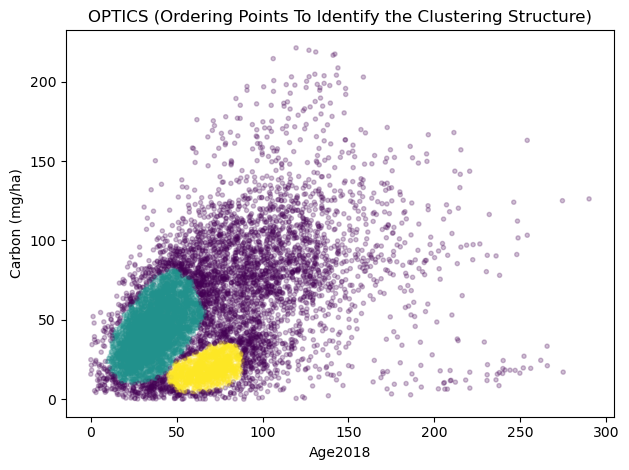

In [167]:
plot1 = plt.scatter(
    # model_data_cluster.get_x()[0][:, 0],
    # model_data_cluster.get_x()[0][:, 1],
    newDF['Age2018'],
    newDF['Carbon2018'],
    
    c=newDF['labels'],
    marker='.', 
    alpha=0.25
)
# print(plot1.get_color())
# plot2 = plt.plot(np.NaN, np.NaN, '-', color='none', label='')

# plot2 = plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
#             marker='s', color='orange', s=100, alpha=0.5, label='pred')
plt.ylabel('Carbon (mg/ha)')
plt.xlabel('Age2018')
plt.title('OPTICS (Ordering Points To Identify the Clustering Structure)')
# plt.legend(handles=[plot1, plot2], loc='best',)
plt.tight_layout()
plt.show()